#### Text Processing for Pre-trained/LLM Models
#### Python
#### Ref: https://www.kaggle.com/code/praveenkotha2/end-to-end-text-processing-for-beginners/notebook

In [23]:
import os
import pickle
import re
import string
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import word2vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
init_notebook_mode(connected=True)
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/vino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/vino/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/vino/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/vino/nltk_data...


True

In [21]:
path = './data/aclImdb/'
# Reading the text data present in the directories. Each review is present as text file.
if not (os.path.isfile('./data/aclImdb/train.csv' and 
                       './data/aclImdb/test.csv')):
    path = './data/aclImdb/'
    train_text = []
    train_label = []
    test_text = []
    test_label = []
    train_data_path_pos = os.path.join(path,'train/pos/')
    train_data_path_neg = os.path.join(path,'train/neg/')

    for data in ['train','test']:
        for label in ['pos','neg']:
            for file in sorted(os.listdir(os.path.join(path,data,label))):
                if file.endswith('.txt'):
                    with open(os.path.join(path,data,label,file)) as file_data:
                        if data=='train':
                            train_text.append(file_data.read())
                            train_label.append( 1 if label== 'pos' else 0)
                        else :
                            test_text.append(file_data.read())
                            test_label.append( 1 if label== 'pos' else 0)

    train_df = pd.DataFrame({'Review': train_text, 'Label': train_label})
    test_df = pd.DataFrame({'Review': test_text, 'Label': test_label})
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    test_df = test_df.sample(frac=1).reset_index(drop=True)
    
    train_df.to_csv('./data/aclImdb/train.csv')
    test_df.to_csv('./data/aclImdb/test.csv')
    
else:
    train_df = pd.read_csv('./data/aclImdb/train.csv',index_col=0)
    test_df = pd.read_csv('./data/aclImdb/test.csv',index_col=0)
    
print('The shape of train data:',train_df.shape)
print('The shape of test data:', test_df.shape)

The shape of train data: (25000, 2)
The shape of test data: (25000, 2)


In [4]:
train_df.head(5)

,Review,Label
0,I stumbled across this (Act-I) by pure dumb lu...,1
1,Alone In The Dark is one BAD movie and tied wi...,0
2,Much in the same way Frank Miller and his Sin ...,1
3,"""Bullfighter"" was made in 2000 but it is being...",0
4,"Weak Bobby ""Pineapple Salsa"" Flay and Mario Ba...",0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  25000 non-null  object
 1   Label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 585.9+ KB


In [6]:
#reduce size for faster processing
train_df=train_df.iloc[0:100]
test_df=test_df.iloc[0:100]

In [7]:
# Defining Functions for Polarity, Subjectivity and Parts of Speech counts
stop_words = stopwords.words('english')

def get_polarity(text):
    try:
        tb = TextBlob(str(text))
        polarity = tb.sentiment.polarity
    except:    
        polarity = 0.0
    return polarity    

def get_subjectivity(text):
    try:
        tb = TextBlob(str(text))
        subjectivity = tb.sentiment.subjectivity
    except:    
        subjectivity = 0.0
    return subjectivity


# pos_dict = {
#     'noun' : ['NN','NNS','NNP','NNPS'],
#     'pronoun' : ['PRP','PRP$'],
#     'adjective' : ['JJ','JJR','JJS'],
#     'adverb' : ['RB','RBR','RBS','WRB'],
#     'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ']
#            }
# def get_pos(text,pos):
#     count = 0
#     try:
#         tokens = nltk.word_tokenize(text)
#         for tag in nltk.pos_tag(tokens):
#             if tag[1] in pos_dict[pos]:
#                 count += 1
#         return count   
#     except:
#         pass

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

def get_pos(text, pos_type):
    words = word_tokenize(text)
    tagged = pos_tag(words)  # Perform POS tagging
    if pos_type == 'noun':
        # Count nouns (NN, NNS, NNP, NNPS are noun tags)
        return sum(1 for word, pos in tagged if pos in ['NN', 'NNS', 'NNP', 'NNPS'])
    if pos_type == 'pronoun':
        return sum(1 for word, pos in tagged if pos in ['PRP','PRP$'])
    if pos_type == 'adjective':
        return sum(1 for word, pos in tagged if pos in ['JJ','JJR','JJS'])
    if pos_type == 'adverb':
        return sum(1 for word, pos in tagged if pos in ['RB','RBR','RBS','WRB'])
    if pos_type == 'verb':
        return sum(1 for word, pos in tagged if pos in ['VB','VBD','VBG','VBN','VBP','VBZ'])
    else:
        return 0  # If pos_type is not 'noun'




In [8]:
# Function for extracting features
def extract_text_features(df):
    df['Word_Count'] = df['Review'].apply(lambda text : len(str(text).split()))
    df['Length'] = df['Review'].apply(len)
    df['Word_Density'] = df['Length']/df['Word_Count']
    df['Stop_Word_Count'] = df['Review'].apply(lambda text: len([word for word in str(text).split() 
                                                                     if word in stop_words]))
    df['Upper_Case_Word_Count'] = df['Review'].apply(lambda text: len([word for word in str(text).split()
                                                                    if word.isupper()]))
    df['Title_Case_Word_Count'] = df['Review'].apply(lambda text: len([word for word in str(text).split()
                                                                    if word.istitle()]))
    df['Numeric_Cnt'] = df['Review'].apply(lambda text:len([word for word in str(text).split()
                                                                    if word.isdigit()]))
    df['Punctuation_Cnt'] = df['Review'].apply(lambda text:len([word for word in str(text).split()
                                                                    if word in string.punctuation]))
    df['Noun_Cnt'] = df['Review'].apply(lambda text: get_pos(str(text),'noun'))
    df['Pronoun_Cnt'] = df['Review'].apply(lambda text: get_pos(str(text),'pronoun'))
    df['Adjective_Cnt'] = df['Review'].apply(lambda text: get_pos(str(text),'adjective'))
    df['Adverb_Cnt'] = df['Review'].apply(lambda text: get_pos(str(text),'adverb'))
    df['Verb_Cnt'] = df['Review'].apply(lambda text: get_pos(str(text),'verb'))
    df['Polarity'] = df['Review'].apply(get_polarity)
    df['Subjectivity'] = df['Review'].apply(get_subjectivity)

    return df

In [9]:
if not (os.path.isfile('./data/aclImdb/train_feat.csv' and 
                       './data/aclImdb/test_feat.csv')):
    train_feat = extract_text_features(train_df)
    test_feat = extract_text_features(test_df)
    train_feat.to_csv('./data/aclImdb/train_feat.csv')
    test_feat.to_csv('./data/aclImdb/test_feat.csv')
else:
    train_feat = pd.read_csv('./data/aclImdb/train_feat.csv',index_col=0)
    test_feat = pd.read_csv('./data/aclImdb/test_feat.csv',index_col=0)

In [10]:
train_feat.head()

,Review,Label,Word_Count,Length,Word_Density,Stop_Word_Count,Upper_Case_Word_Count,Title_Case_Word_Count,Numeric_Cnt,Punctuation_Cnt,Noun_Cnt,Pronoun_Cnt,Adjective_Cnt,Adverb_Cnt,Verb_Cnt,Polarity,Subjectivity
0,I stumbled across this (Act-I) by pure dumb lu...,1,193,1047,5.424870,89,5,20,0,0,48,19,12,20,43,0.122024,0.478409
1,Alone In The Dark is one BAD movie and tied wi...,0,219,1186,5.415525,75,10,41,1,0,106,11,17,12,33,-0.342969,0.680171
2,Much in the same way Frank Miller and his Sin ...,1,415,2374,5.720482,175,3,59,0,1,146,19,60,23,54,0.124717,0.401055
3,"""Bullfighter"" was made in 2000 but it is being...",0,125,707,5.656000,48,2,18,3,0,41,8,11,6,30,-0.020933,0.578869
4,"Weak Bobby ""Pineapple Salsa"" Flay and Mario Ba...",0,124,690,5.564516,49,4,27,0,0,48,8,9,13,23,0.077500,0.550000


In [11]:
pol_1 = train_feat[train_feat['Label']==1]['Polarity'].values
pol_0 = train_feat[train_feat['Label']==0]['Polarity'].values

pol_data=[pol_1,pol_0]
group_labels=['Positive','Negative']
colors = ['#A56CC1', '#63F5EF']

fig = ff.create_distplot(pol_data, group_labels, colors=colors,
                         bin_size=.05, show_rug=False)

fig.layout.margin.update({'t':50, 'l':100})
fig['layout'].update(title='Polarity Distplot')
fig.layout.template = 'plotly_dark'

py.iplot(fig, filename='Polarity')

From the above plot, we could clearly see 'Polarity' feature is able to seperate Positive and Negative reviews. Positive reviews tending to +1 and negative reviews tending to -1.
The average polarity of Positive reviews is greater than that of Negative reviews.

In [12]:
print('The average polarity of all Positive reviews:',round(np.mean(train_feat[train_feat['Label']==1]['Polarity'].values),2))
print('The average polarity of all Negative reviews:',round(np.mean(train_feat[train_feat['Label']==0]['Polarity'].values),2))

The average polarity of all Positive reviews: 0.17
The average polarity of all Negative reviews: 0.0


In [13]:
pol_1 = train_feat[train_feat['Label']==1]['Subjectivity'].values
pol_0 = train_feat[train_feat['Label']==0]['Subjectivity'].values

pol_data=[pol_1,pol_0]
group_labels=['Positive','Negative']
colors = ['#A56CC1', '#63F5EF']

fig = ff.create_distplot(pol_data, group_labels, colors=colors,
                         bin_size=.05, show_rug=False)

fig['layout'].update(title='Subjectivity Distplot')
fig.layout.template = 'plotly_dark'

py.iplot(fig, filename='Subjectivity Distplot')

Subjectivity is not able to seperate Positive and Negative reviews. Both the distributions are overlapping each other.


In [14]:
pol_1 = train_feat[train_feat['Label']==1]['Word_Count'].values
pol_0 = train_feat[train_feat['Label']==0]['Word_Count'].values

pol_data=[pol_1,pol_0]
group_labels=['Positive','Negative']
colors = ['#A56CC1', '#63F5EF']

fig = ff.create_distplot(pol_data, group_labels, colors=colors,
                         bin_size=50, show_rug=False)

fig['layout'].update(title='Word Count Distplot')
fig.layout.template = 'plotly_dark'

py.iplot(fig, filename='Word Count Distplot')

In [15]:
print('The average word count of all Positive reviews:',round(np.mean(train_feat[train_feat['Label']==1]['Word_Count'].values),2))
print('The average word count of all Negative reviews:',round(np.mean(train_feat[train_feat['Label']==0]['Word_Count'].values),2))

The average word count of all Positive reviews: 289.02
The average word count of all Negative reviews: 229.85


The Average word count of Positive reviews is greater than that of Negative reviews.
Positive reviews are having higher tendency of having higher word counts, we could also see the same from the above plot.

In [16]:
# Preparing the data for applying to T-SNE
scaler = MinMaxScaler()
col_filter = [col for col in train_feat.columns if col not in ['Review', 'Label'] ]
train_viz = scaler.fit_transform(train_feat[col_filter][:10000])
y_label = train_feat['Label'][:10000].values

In [17]:
# Using TSNE for Dimentionality reduction for 15 Features to 2 dimentions
tsne2d = TSNE(n_components=2,init='random',random_state=101,n_iter=1000,verbose=2,angle=0.5).fit_transform(train_viz)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.328092
[t-SNE] Computed conditional probabilities in 0.003s
[t-SNE] Iteration 50: error = 49.3773499, gradient norm = 0.6148217 (50 iterations in 0.007s)
[t-SNE] Iteration 100: error = 52.2307358, gradient norm = 0.5610502 (50 iterations in 0.008s)
[t-SNE] Iteration 150: error = 51.7409286, gradient norm = 0.4664895 (50 iterations in 0.007s)
[t-SNE] Iteration 200: error = 54.8704720, gradient norm = 0.4169692 (50 iterations in 0.007s)
[t-SNE] Iteration 250: error = 51.1784744, gradient norm = 0.4926890 (50 iterations in 0.007s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.178474
[t-SNE] Iteration 300: error = 0.4350174, gradient norm = 0.0107713 (50 iterations in 0.006s)
[t-SNE] Iteration 350: error = 0.3601596, gradient norm = 0.0029663 (

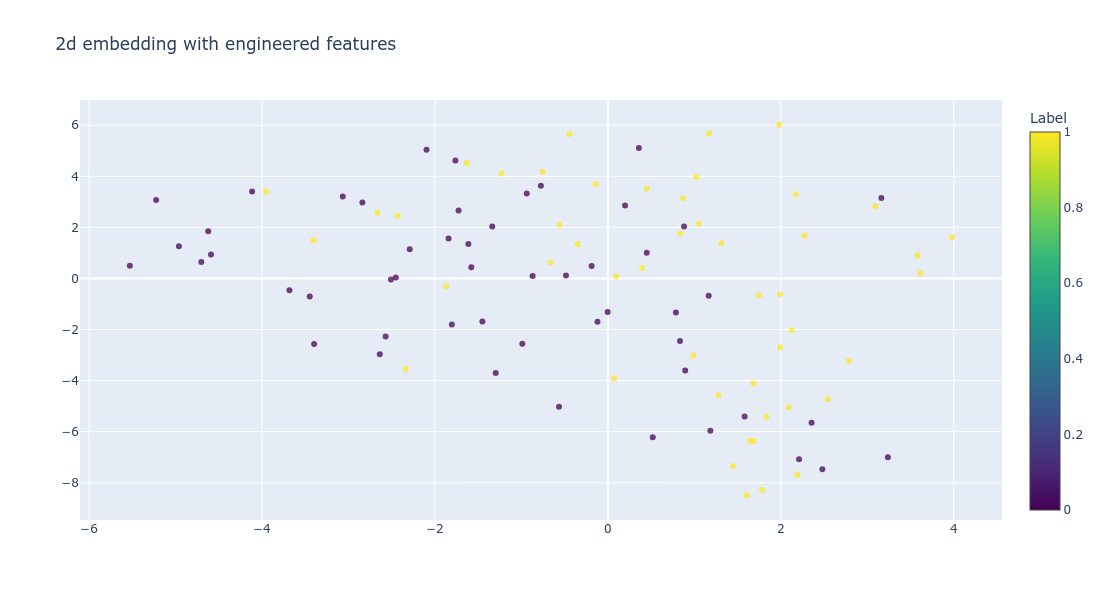

In [18]:
#2D Plot
trace1 = go.Scatter(
    x=tsne2d[:,0],
    y=tsne2d[:,1],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y_label,
        colorscale = 'Viridis',
        colorbar = dict(title = 'Label'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=600, width=600, title='2d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='2d embedding with engineered features')

##### Folllowing are the steps followed for text preprocessing:

Converting the text to Lower case.
Removing all the characters other than alpha numeric characters.
Tokenizing the sentence.
Removing stopwords and words with character length one.
Lemmatization of each word

In [19]:
# Defining function to preprocess the text
lemmatizer = WordNetLemmatizer()
stop_words.append('br')

def preprocess(text):
    text = str(text.encode('utf-8')).lower()
    text = re.sub(r'[^A-Za-z1-9]+',' ',text)
    text_tokens = word_tokenize(text)
    
    text_process = []
    for word in text_tokens:
        if word not in stop_words and len(word)>1:
            text_process.append(str(lemmatizer.lemmatize(word)))
    text = ' '.join(text_process)       
            
    return text

In [24]:
if not (os.path.isfile(path+'train_feat_clean.csv' 
                       and path+'test_feat_clean.csv')):
    train_feat['Review_Clean'] = train_feat['Review'].apply(preprocess)
    test_feat['Review_Clean'] = test_feat['Review'].apply(preprocess)
    train_feat.to_csv('train_feat_clean.csv')
    test_feat.to_csv('test_feat_clean.csv')
else:    
    train_feat = pd.read_csv(path+'train_feat_clean.csv',index_col=0)
    test_feat  = pd.read_csv(path+'test_feat_clean.csv',index_col=0)

In [25]:
train_feat.head()

,Review,Label,Word_Count,Length,Word_Density,Stop_Word_Count,Upper_Case_Word_Count,Title_Case_Word_Count,Numeric_Cnt,Punctuation_Cnt,Noun_Cnt,Pronoun_Cnt,Adjective_Cnt,Adverb_Cnt,Verb_Cnt,Polarity,Subjectivity,Review_Clean
0,I stumbled across this (Act-I) by pure dumb lu...,1,193,1047,5.424870,89,5,20,0,0,48,19,12,20,43,0.122024,0.478409,stumbled across act pure dumb luck decade ago ...
1,Alone In The Dark is one BAD movie and tied wi...,0,219,1186,5.415525,75,10,41,1,0,106,11,17,12,33,-0.342969,0.680171,alone dark one bad movie tied deuce bigalow wo...
2,Much in the same way Frank Miller and his Sin ...,1,415,2374,5.720482,175,3,59,0,1,146,19,60,23,54,0.124717,0.401055,much way frank miller sin city comic used blac...
3,"""Bullfighter"" was made in 2000 but it is being...",0,125,707,5.656000,48,2,18,3,0,41,8,11,6,30,-0.020933,0.578869,bullfighter made released video year later rea...
4,"Weak Bobby ""Pineapple Salsa"" Flay and Mario Ba...",0,124,690,5.564516,49,4,27,0,0,48,8,9,13,23,0.077500,0.550000,weak bobby pineapple salsa flay mario batali b...


In [26]:
print('Review before Text preprocessing:\n',train_feat['Review'][1])
print('\nReview after Text preprocessing:\n',train_feat['Review_Clean'][1])

Review before Text preprocessing:
 Alone In The Dark is one BAD movie and tied with Deuce Bigalow for worst movie of the year. I wish that was ALL I had to say but of course the IMDb stipulates a word count and all that.<br /><br />I'm in two minds about what kind of bad movie is a worse kind of bad movie. A low budget dreck like Red Zone Cuba, Monster A Go Go and Manos. Or a huge budget disgrace like Gigli, Superbabies or this guff. You see movies like Monster A Go Go and Manos happen because the director hasn't a clue. Movies like this happen because the director is a stupid, money grabbing idiot who simply doesn't care about his audience.<br /><br />It's more shocking when you consider that Uwe Boll (The mastermind behind this shocking crap and already has some real garbage under his belt) has created something that only happens once in a blue moon. The really terribly bad horror film. Everything about it is a mess. Cheesy CGI, bad plot, insane random camera cuts and appalling sound

In [27]:
# Extracting 15 Engineered features as a seperate Dataframe
feat_15_cols = [col for col in train_feat.columns if col not in ['Review','Label','Review_Clean']]
train_feat_15 = train_feat[feat_15_cols]
test_feat_15 = test_feat[feat_15_cols]

train_feat_15.reset_index(drop=True, inplace=True)
test_feat_15.reset_index(drop=True, inplace=True)

In [28]:
train_feat_15.head()

,Word_Count,Length,Word_Density,Stop_Word_Count,Upper_Case_Word_Count,Title_Case_Word_Count,Numeric_Cnt,Punctuation_Cnt,Noun_Cnt,Pronoun_Cnt,Adjective_Cnt,Adverb_Cnt,Verb_Cnt,Polarity,Subjectivity
0,193,1047,5.424870,89,5,20,0,0,48,19,12,20,43,0.122024,0.478409
1,219,1186,5.415525,75,10,41,1,0,106,11,17,12,33,-0.342969,0.680171
2,415,2374,5.720482,175,3,59,0,1,146,19,60,23,54,0.124717,0.401055
3,125,707,5.656000,48,2,18,3,0,41,8,11,6,30,-0.020933,0.578869
4,124,690,5.564516,49,4,27,0,0,48,8,9,13,23,0.077500,0.550000


#### Following are the techniques that we can use for text featurization:

##### Bag Of Words (BOW) featurization
##### Term Frequency-Inverse Document Frequency (TF-IDF) featurization
##### Word Embeddings (Word2Vec) featurization
##### Average Word2Vec
##### TF-IDF Word2Vec